In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from projimmo.data import *
from projimmo.preprocessor import *
from projimmo.model import *
from projimmo.optimize_model import *

In [2]:
query = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.DVF_{DATA_YEAR}
    """
#chemin d'accès à nos fichiers locaux
data_query_cache_path=Path(f"raw_data/valeursfoncieres-2023.txt")

# import de nos data, ici à partir du fichier mais plus tard dans la base de data de bigquer
df= get_data_with_cache(query=query,
gcp_project=GCP_PROJECT,
        cache_path=data_query_cache_path,
        data_has_header=True
   )

#Pour écrire dans big query le df notre choix
#load_data_to_bq(
#        df_de_notre_choix,
 #       gcp_project=GCP_PROJECT,
 #       bq_dataset=BQ_DATASET,
 #       table=f'processed_{DATA_SIZE}',
 #       truncate=True
  #  )
#appel à la fonction clean_data
df_0=clean_data(df)
#appel à la fonction clean_outliers
df_1=clean_outliers(df_0)
#on passe notre df dans la pipeline
X_1=df_1.drop(columns="valeur_fonciere")
y_1=df_1.valeur_fonciere
df_2=preprocess_features(X_1)



Load data from local CSV...
✅ Data loaded, with shape (3727005, 43)
✅ X_processed, with shape (75169, 40)


In [ ]:
X_1.head(20)

,type_de_voie,nombre_de_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,month_mutation,year_mutation,somme_surface_carrez,departement
654,RUE,1,2,95.0,4.0,0.0,1,2023,97.70,13
1027,RUE,2,2,95.0,4.0,0.0,1,2023,94.79,13
1598,RUE,1,2,45.0,2.0,0.0,1,2023,46.87,13
2101,AUTRE,1,2,58.0,3.0,0.0,1,2023,60.30,13
2112,RUE,1,2,65.0,3.0,0.0,2,2023,64.20,13
2268,RUE,1,2,93.0,3.0,0.0,1,2023,109.20,13
2564,RUE,1,2,61.0,2.0,0.0,1,2023,67.23,13
2781,RTE,1,2,100.0,5.0,0.0,1,2023,120.67,13
2998,RUE,1,2,80.0,4.0,0.0,1,2023,76.65,13
3374,RTE,1,2,48.0,3.0,0.0,1,2023,39.03,13


In [ ]:
df_2.shape

(75664, 40)

In [ ]:
df_1.head(20)
df_1.valeur_fonciere.max(),df_1.valeur_fonciere.min()

(4503500.0, 1.0)

In [ ]:
min_value = df_1['valeur_fonciere'].min()

# Compter combien de valeurs correspondent à la valeur minimale
count_min = (df_1['valeur_fonciere'] == min_value).sum()

print(f"Nombre de valeurs égales à la valeur minimale : {count_min}")

Nombre de valeurs égales à la valeur minimale : 4


In [ ]:
df_1.valeur_fonciere.mean()

325332.562380128

In [ ]:
df_1.valeur_fonciere.median()

215000.0

# 1. Baseline

#### MOYENN: 325332.562380128
#### MAX, MIN:(4503500.0, 1.0)
#### MEDIAN: 215000.0

# 2. Test de 3 modèles: Linear regression, KNN, XGB

## a. fonction générale

In [ ]:
def pre_model(X,y,model_type):
    X_train,X_test,y_train,y_test=split_df(X,y)

    model=initialize_model(model_type)
    # Effectuer la validation croisée
    cv_results = cross_validate_model(X_train, y_train, model)
    print("\nSans validation croisée:")
    fitted_model=train_model(X_train,y_train,model)
    metrics=evaluate_model(X_test,y_test,fitted_model, model_type)
    return metrics

## b. Linear Regression

In [ ]:
X=df_2.copy()
y=y_1.copy()
model_type="LR" #possible: "KNR","LR","XGB"
metrics_lr=pre_model(X,y,model_type)

Validation croisée :
MSE moyen: 0.27
Écart-type du MSE: 0.02

Sans validation croisée:
Mean Squared Error (MSE): 0.27274267066168384
Mean Absolute Error (MAE): 0.35237243331513773
R-squared (R²) Score: 0.5493213697025019
Root Mean Squared Error (RMSE): 0.5222477100588224
Mean Squared Logarithmic Error (MSLE): 0.0017962151747186817


# c. KNN

In [ ]:
X=df_2.copy()
y=y_1.copy()
model_type="KNR" #possible: "KNR","LR","XGB"
metrics_knr=pre_model(X,y,model_type)

Validation croisée :
MSE moyen: 0.24
Écart-type du MSE: 0.02

Sans validation croisée:
Mean Squared Error (MSE): 0.2370256692803165
Mean Absolute Error (MAE): 0.3368114313929736
R-squared (R²) Score: 0.6083399648560832
Root Mean Squared Error (RMSE): 0.4868528209637041
Mean Squared Logarithmic Error (MSLE): 0.0015837935177997029


# d. XGB

In [ ]:
X=df_2.copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"
metrics_xgb=pre_model(X,y,model_type)


Validation croisée :
MSE moyen: 0.21
Écart-type du MSE: 0.01

Sans validation croisée:
Mean Squared Error (MSE): 0.2152495001270144
Mean Absolute Error (MAE): 0.3052681875866953
R-squared (R²) Score: 0.6443227982841184
Root Mean Squared Error (RMSE): 0.4639498896723809
Mean Squared Logarithmic Error (MSLE): 0.0014661770087148211


# Conclusion

In [ ]:
df_lr = pd.DataFrame(metrics_lr, index=[0])
df_knr = pd.DataFrame(metrics_knr, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_lr.rename(index={0: 'Linear Regression'}),
    df_knr.rename(index={0: 'KNR'}),
    df_xgb.rename(index={0: 'XGB'})
])
compa

,mse,mae,r2,rmse,msle
Linear Regression,0.272743,0.352372,0.549321,0.522248,0.001796
KNR,0.237026,0.336811,0.608340,0.486853,0.001584
XGB,0.215250,0.305268,0.644323,0.463950,0.001466


### Meilleur modèle: XGB

# 3. Amélioration du modèle XGB

## a. Etude des features

In [ ]:
X=df_2.copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"
X_train,X_test,y_train,y_test=split_df(X,y)
model_xgb=initialize_model(model_type)

fitted_model_xgb=train_model(X_train,y_train,model_xgb)

# Importance des caractéristiques
importances = fitted_model_xgb.feature_importances_
# Création d'un DataFrame pour visualiser les importances
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importances_df

,Feature,Importance
37,departement_75,0.654893
2,somme_surface_carrez,0.134781
36,departement_69,0.031954
27,month_mutation_12,0.016208
34,departement_59,0.015530
0,surface_reelle_bati,0.012590
30,departement_31,0.012008
32,departement_34,0.011426
15,type_de_voie_RUE,0.008421
14,type_de_voie_RTE,0.008215


## b. Interprétation

#### Caractéristiques Principales : Les caractéristiques avec les plus hauts scores d'importance, comme departement_75 avec 0.511535 et somme_surface_carrez avec 0.165999, sont celles qui ont le plus d'impact sur les prédictions du modèle. Cela suggère que ces variables sont cruciales pour le modèle.

#### Caractéristiques Peu Importantes : Les variables avec des importances proches de zéro, comme type_de_voie_PL ou code_type_local_2, ont un impact négligeable sur les prédictions. Ces caractéristiques pourraient être considérées pour une éventuelle suppression si elles n'apportent pas de valeur ajoutée.

#### NB: Ici, nous garderons l'année puisque le modèle est entrainé que sur 2023 pour le moment

## c. Permutation importance

#### La permutation importance évalue l'importance d'une feature en mesurant la dégradation de la performance du modèle lorsque les valeurs de cette feature sont permutées.


In [ ]:
# Calcul de l'importance des caractéristiques par permutation
results = permutation_importance(fitted_model_xgb, X_test, y_test, scoring='neg_mean_squared_error')

# Création d'un DataFrame pour visualiser les importances
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

perm_importance_df


,Feature,Importance
37,departement_75,4.156248e-01
2,somme_surface_carrez,4.113649e-01
0,surface_reelle_bati,2.465471e-02
30,departement_31,8.930979e-03
38,nombre_pieces_principales,6.752209e-03
34,departement_59,6.230615e-03
36,departement_69,4.824627e-03
39,nombre_de_lots,4.545052e-03
14,type_de_voie_RTE,3.441250e-03
27,month_mutation_12,3.046894e-03


## d. Colonne à forte influence 

In [ ]:
# Exemple de seuil pour les importances
threshold = 0.003
important_features= importances_df[importances_df['Importance'] > threshold]

# Affichage des caractéristiques importantes
important_features

,Feature,Importance
37,departement_75,0.654893
2,somme_surface_carrez,0.134781
36,departement_69,0.031954
27,month_mutation_12,0.016208
34,departement_59,0.015530
0,surface_reelle_bati,0.012590
30,departement_31,0.012008
32,departement_34,0.011426
15,type_de_voie_RUE,0.008421
14,type_de_voie_RTE,0.008215


## e. Essai du modèle sans Paris

In [ ]:

X_sansP=df_2.drop(columns="departement_75").copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"

metrics_xgb_sansP=pre_model(X_sansP,y,model_type)


Validation croisée :
MSE moyen: 0.22
Écart-type du MSE: 0.01

Sans validation croisée:
Mean Squared Error (MSE): 0.2297534095649265
Mean Absolute Error (MAE): 0.3212840632245967
R-squared (R²) Score: 0.6203566105820653
Root Mean Squared Error (RMSE): 0.47932599508573126
Mean Squared Logarithmic Error (MSLE): 0.0015846886997348936


In [ ]:
df_sansP = pd.DataFrame(metrics_xgb_sansP, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_sansP.rename(index={0: 'XGB sans Paris'}),
])
compa

,mse,mae,r2,rmse,msle
XGB,0.215250,0.305268,0.644323,0.463950,0.001466
XGB sans Paris,0.229753,0.321284,0.620357,0.479326,0.001585


In [ ]:
X_train,X_test,y_train,y_test=split_df(X_sansP,y)
model_sansP=initialize_model(model_type)

fitted_model_sansP=train_model(X_train,y_train,model_sansP)

# Importance des caractéristiques
importances = fitted_model_sansP.feature_importances_
# Création d'un DataFrame pour visualiser les importances
importances_df_sansP = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importances_df_sansP

,Feature,Importance
29,departement_13,0.129182
2,somme_surface_carrez,0.129159
32,departement_34,0.103881
36,departement_69,0.101841
30,departement_31,0.100108
34,departement_59,0.097105
33,departement_44,0.091619
31,departement_33,0.086815
15,type_de_voie_RUE,0.022166
35,departement_67,0.019174


## f. Essai du modèle sans département

In [ ]:

# Créer une liste des colonnes qui ne commencent pas par 'departement'
colonnes_sans_departement = [col for col in df_2.columns if not col.startswith('departement')]

# Créer un nouveau DataFrame avec ces colonnes
X_sans_dpt = df_2[colonnes_sans_departement].copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"

metrics_xgb_sans_dpt=pre_model(X_sans_dpt,y,model_type)
df_sans_dpt = pd.DataFrame(metrics_xgb_sans_dpt, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_sans_dpt.rename(index={0: 'XGB sans departement'}),
])
compa

Validation croisée :
MSE moyen: 0.40
Écart-type du MSE: 0.01

Sans validation croisée:
Mean Squared Error (MSE): 0.39642878874513765
Mean Absolute Error (MAE): 0.47501694747414325
R-squared (R²) Score: 0.34494304434024103
Root Mean Squared Error (RMSE): 0.6296259117485061
Mean Squared Logarithmic Error (MSLE): 0.0024449676141742164


,mse,mae,r2,rmse,msle
XGB,0.215250,0.305268,0.644323,0.463950,0.001466
XGB sans departement,0.396429,0.475017,0.344943,0.629626,0.002445


## Conclusion
#### Grosse influence de laspect géographique

## g. Modèle avec les 22 features les plus influentes (+ année)

In [ ]:
# Exemple de seuil pour les importances
threshold = 0.003
important_features= importances_df[importances_df['Importance'] > threshold]

# Affichage des caractéristiques importantes
important_features
X_important=df_2[important_features['Feature']].copy()
X_important['year_mutation_2023']=df_2['year_mutation_2023']
X_important

y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"

metrics_important_features=pre_model(X_important,y,model_type)
df__important_features= pd.DataFrame(metrics_important_features, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df__important_features.rename(index={0: 'XGB avec 22 features + importantes'}),
])
compa

Validation croisée :
MSE moyen: 0.21
Écart-type du MSE: 0.01

Sans validation croisée:
Mean Squared Error (MSE): 0.2161301364056803
Mean Absolute Error (MAE): 0.3054755274914414
R-squared (R²) Score: 0.6428676392842576
Root Mean Squared Error (RMSE): 0.46489798494474066
Mean Squared Logarithmic Error (MSLE): 0.0014674980697978704


,mse,mae,r2,rmse,msle
XGB,0.21525,0.305268,0.644323,0.463950,0.001466
XGB avec 22 features + importantes,0.21613,0.305476,0.642868,0.464898,0.001467


# 4. PCA

#### Le PCA (Principal Component Analysis) est une technique de réduction de dimensionnalité utilisée pour simplifier les données tout en conservant le maximum de leur variance. 

#### Le PCA est une méthode statistique qui transforme un ensemble de variables corrélées en un ensemble de variables non corrélées appelées composantes principales. Ces nouvelles variables sont des combinaisons linéaires des variables d'origine et sont classées par ordre d'importance (variabilité des données).

In [ ]:
def test_pca(df,y, model_type,n_components=df_2.shape[1]):
    X_train,X_test,y_train,y_test=split_df(df,y)
    pca = PCA(n_components=n_components)
    # Appliquer le PCA sur X_train et X_test
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model_XGB = initialize_model(model_type)

    # Validation croisée sur les données transformées par PCA
    cv_results_XGB_pca = cross_validate_model(X_train_pca, y_train, model_XGB)

    # Entraîner le modèle sur les données réduites
    fitted_model_XGB_pca = train_model(X_train_pca, y_train, model_XGB)
    print("\nSans validation croisée:")
    # Évaluer le modèle sur les données de test transformées
    metrics_XGB_pca = evaluate_model(X_test_pca, y_test, fitted_model_XGB_pca, model_type)


    return metrics_XGB_pca


## a. PCA avec la moitié des features

In [ ]:
n_components = int(X_train.shape[1]/2) # Vous pouvez aussi définir un nombre fixe de composantes comme n_components=20
model_type = "XGB"
metrics_XGB_pca =test_pca(df_2,y_1, model_type,n_components)
df_XGB_pca = pd.DataFrame(metrics_XGB_pca, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_XGB_pca.rename(index={0: 'XGB avce PCA'}),
])
compa

Validation croisée :
MSE moyen: 0.21
Écart-type du MSE: 0.01

Sans validation croisée:
Mean Squared Error (MSE): 0.22304540726535124
Mean Absolute Error (MAE): 0.3100850239673806
R-squared (R²) Score: 0.6314408801650784
Root Mean Squared Error (RMSE): 0.4722768332930922
Mean Squared Logarithmic Error (MSLE): 0.0015352834491716807


,mse,mae,r2,rmse,msle
XGB,0.215250,0.305268,0.644323,0.463950,0.001466
XGB avce PCA,0.223045,0.310085,0.631441,0.472277,0.001535


## b. Recherche du nombre de composantes pour PCA

### ***Choix de n_components par validation croisée***

In [ ]:

# Test de différents nombres de composants
n_components_range = range(1,df_2.shape[1] + 1)
scores = []

for n in n_components_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(df_2)
    model_XGB = initialize_model(model_type)
    score = cross_val_score(model_XGB, X_pca, y_1, cv=5).mean()
    scores.append(score)


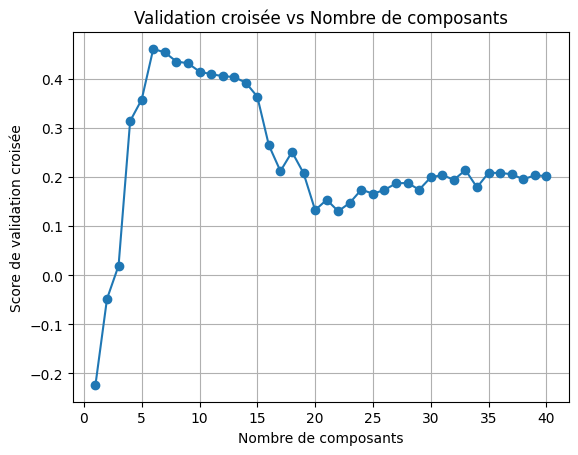

In [ ]:

# Tracer les scores
plt.plot(n_components_range, scores, marker='o')
plt.xlabel('Nombre de composants')
plt.ylabel('Score de validation croisée')
plt.title('Validation croisée vs Nombre de composants')
plt.grid(True)
plt.show()

#### **Graphe se stabilise à 35**

In [ ]:
# Trouver l'indice du meilleur score
best_index = np.argmax(scores)
# Correspondre l'indice avec le nombre de composants
best_n_components = n_components_range[best_index]

best_n_components

6

#### **Meilleur score atteint à 6**

### ***Verification par graph de la variance expliquée cumulée***


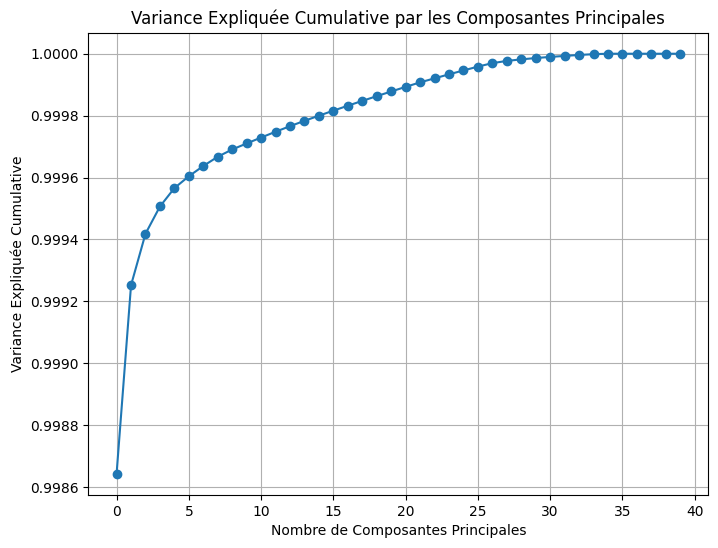

In [ ]:
# Appliquer PCA
pca = PCA()
X_pca = pca.fit_transform(df_2)

# Calculer la variance expliquée cumulée
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Tracer la variance expliquée cumulée
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.title('Variance Expliquée Cumulative par les Composantes Principales')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Variance Expliquée Cumulative')
plt.grid(True)
plt.show()

## c. Essai avec 6 puis 32

In [ ]:
metrics_XGB_pca_6=test_pca(df_2,y_1, model_type,n_components = 6)
df_pca_6 = pd.DataFrame(metrics_XGB_pca_6, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_pca_6.rename(index={0: 'PCA 6 composantes'}),
])
compa

Validation croisée :
MSE moyen: 0.22
Écart-type du MSE: 0.01

Sans validation croisée:
Mean Squared Error (MSE): 0.22965708417869343
Mean Absolute Error (MAE): 0.31398879539625707
R-squared (R²) Score: 0.620515778170419
Root Mean Squared Error (RMSE): 0.4792255045160821
Mean Squared Logarithmic Error (MSLE): 0.001567347218444234


,mse,mae,r2,rmse,msle
XGB,0.215250,0.305268,0.644323,0.463950,0.001466
PCA 6 composantes,0.229657,0.313989,0.620516,0.479226,0.001567


In [ ]:
metrics_XGB_pca_35=test_pca(df_2,y_1, model_type,n_components = 35)
df_pca_35 = pd.DataFrame(metrics_XGB_pca_35, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_pca_35.rename(index={0: 'PCA 35 composantes'}),
])
compa

Validation croisée :
MSE moyen: 0.21
Écart-type du MSE: 0.01

Sans validation croisée:
Mean Squared Error (MSE): 0.21166470190426293
Mean Absolute Error (MAE): 0.30602746454381885
R-squared (R²) Score: 0.6502463010092441
Root Mean Squared Error (RMSE): 0.4600703227814884
Mean Squared Logarithmic Error (MSLE): 0.0014359797938253021


,mse,mae,r2,rmse,msle
XGB,0.215250,0.305268,0.644323,0.46395,0.001466
PCA 35 composantes,0.211665,0.306027,0.650246,0.46007,0.001436


## Conclusion: mieux avec 35

### Interprétation résultats:
#### Résultats de validation croisée et sans validation croisée montrent des valeurs de MSE (Mean Squared Error) très proches => modèle consistant et ne souffre pas de sur-apprentissage (overfitting) ni de sous-apprentissage (underfitting), ce qui est positif. 



#### MAE proche de MSE:  erreurs dans prédictions probablement uniformément réparties, sans trop d'erreurs très grandes.


#### R2 ok

